# **Data Mining : Final Project**

<b>Name:</b>Risha R Dinesh<br>
<b>Professor:</b> Yasser Abduallah<br>
<b>UCID:</b> rrr62 <br>
<b>Email_Id:</b> rrr62@njit.edu<br>

<b>Project Objective:</b><br>To develop and compare multiple machine learning models for accurately predicting diabetes risk using standardized medical features, evaluating their performance through comprehensive metrics and ROC analysis.

<b>Install required packages:</b>

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

Note: you may need to restart the kernel to use updated packages.


**Import Statements**  
This cell imports the necessary libraries:

1. **Basic Data Processing and Analysis**: `pandas`, `numpy`  
2. **Visualization Libraries**: `matplotlib`, `seaborn`  
3. **Warning Suppression**  
4. **Scikit-learn Components**:  
   `StandardScaler`, `SVC`, `RandomForestClassifier`, `GridSearchCV`,  
   `StratifiedKFold`, `train_test_split`, `confusion_matrix`,  
   `roc_auc_score`, `roc_curve`, `auc`, `brier_score_loss`  
5. **TensorFlow and Environment Settings**: `Sequential`, `Dense`, `LSTM`


In [2]:
# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import logging

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, brier_score_loss

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Configure warnings and logging to minimize unnecessary output
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


<b>Data Loading</b><br>Loads the diabetes dataset from 'pima_diabetes_400.csv' and creates a pandas DataFrame for data manipulation

In [3]:
# Load and preprocess data
print("Loading and preprocessing data...")
diabetes = pd.read_csv('dinesh_risha_finaltermproj.csv')
print("\nDataset Summary:")
print("-" * 50)
print(diabetes.describe())
print("\nDataset Info:")
print("-" * 50)
print(diabetes.info())

Loading and preprocessing data...

Dataset Summary:
--------------------------------------------------
       Pregnancies    Glucose  BloodPressure  SkinThickness     Insulin  \
count   400.000000  400.00000     400.000000     400.000000  400.000000   
mean      3.952500  121.24000      69.060000      20.327500   81.250000   
std       3.369514   32.68437      19.011575      15.599796  121.597254   
min       0.000000    0.00000       0.000000       0.000000    0.000000   
25%       1.000000  100.00000      64.000000       0.000000    0.000000   
50%       3.000000  116.50000      71.000000      23.000000   36.000000   
75%       6.000000  143.00000      80.000000      32.000000  128.250000   
max      17.000000  197.00000     122.000000      60.000000  846.000000   

             BMI  DiabetesPedigreeFunction         Age     Outcome  
count  400.00000                400.000000  400.000000  400.000000  
mean    32.10775                  0.487915   33.092500    0.380000  
std      8.137

<br><b>Missing Value Imputation Function</b><br>The function handles missing values in medical measurements that are incorrectly recorded as zeros in the diabetes dataset. Since medical measurements like glucose or blood pressure cannot be zero in living patients, these values are treated as missing data and replaced with meaningful estimates.

In [4]:
# Impute missing values
def impute_missing_data(input_dataframe):
    
    columns_for_imputation = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for target_column in columns_for_imputation:
        input_dataframe.loc[input_dataframe[target_column] == 0, target_column] = np.nan
        input_dataframe[target_column].fillna(input_dataframe[target_column].median(), inplace=True)
    return input_dataframe

diabetes = impute_missing_data(diabetes)

In [5]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,121.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,121.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,121.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


<b>Feature and Label Splitting</b><br>
The code separates the diabetes dataset into two components:
1. Features (X): Input variables used to make predictions
2. Labels (y): Target variable to be predicted

In [6]:
# Split features and labels
features = diabetes.iloc[:, :-1]
labels = diabetes.iloc[:, -1]

<br><b>Data Balance Analysis</b><br>
The code analyzes class distribution in the diabetes dataset by:
1. Counting positive cases (patients with diabetes)
2. Counting negative cases (patients without diabetes)
3. Calculating percentages for each class

In [7]:
# Display data balance information
positive_outcomes = len(labels[labels == 1])
negative_outcomes = len(labels[labels == 0])
total_samples = len(labels)
print('\nData Balance Analysis:')
print('-' * 50)
print(f'Positive Outcomes: {positive_outcomes} ({(positive_outcomes/total_samples)*100:.2f}%)')
print(f'Negative Outcomes: {negative_outcomes} ({(negative_outcomes/total_samples)*100:.2f}%)')


Data Balance Analysis:
--------------------------------------------------
Positive Outcomes: 152 (38.00%)
Negative Outcomes: 248 (62.00%)


<br><b>Train Test Split</b><br>
The code splits the dataset into training and testing sets while maintaining the class distribution of the target variable.

In [8]:
# Perform train-test split and standardization
features_train_all, features_test_all, labels_train_all, labels_test_all = train_test_split(
    features, labels, test_size=0.1, random_state=21, stratify=labels)

# Reset indices for the training and testing sets
for dataset in [features_train_all, features_test_all, labels_train_all, labels_test_all]:
    dataset.reset_index(drop=True, inplace=True)


<br><b>Feature Standardization</b><br>
The code standardizes feature values by removing the mean and scaling to unit variance, which is essential for machine learning algorithms to perform optimally.

In [9]:
# Standardize features
scaler = StandardScaler()
features_train_all_std = pd.DataFrame(
    scaler.fit_transform(features_train_all),
    columns=features_train_all.columns)

features_test_all_std = pd.DataFrame(
    scaler.transform(features_test_all),
    columns=features_test_all.columns)

In [10]:
features_train_all_std.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02
mean,-1.110223e-16,-6.908054e-17,-1.332268e-16,-1.973730e-17,-3.947460e-17,6.908054e-16,7.894919e-17,-2.627528e-16
std,1.001392e+00,1.001392e+00,1.001392e+00,1.001392e+00,1.001392e+00,1.001392e+00,1.001392e+00,1.001392e+00
min,-1.165391e+00,-2.608533e+00,-3.414367e+00,-2.617854e+00,-1.278584e+00,-1.983277e+00,-1.158101e+00,-1.085505e+00
25%,-8.742456e-01,-7.256323e-01,-6.703190e-01,-4.816377e-01,-2.113704e-01,-7.157254e-01,-6.731933e-01,-8.230003e-01
50%,-2.919544e-01,-1.970989e-01,-2.466057e-02,-6.922923e-03,-2.113704e-01,-4.712691e-02,-3.302444e-01,-2.979912e-01
75%,5.814825e-01,6.948012e-01,6.209979e-01,4.677918e-01,-1.362510e-01,5.553082e-01,4.617706e-01,6.645253e-01
max,3.784084e+00,2.445568e+00,4.010705e+00,3.672116e+00,7.300568e+00,4.800212e+00,5.169587e+00,3.114568e+00


<b>Hyperparameter Optimization</b><br>
1. Implements a hyperparameter optimization process for Random Forest and Support Vector Machine (SVM) classifiers in a diabetes prediction system. 
2. The primary objective is to identify the optimal configuration of model parameters that maximize prediction performance while maintaining computational efficiency.
3. The optimization process employs GridSearchCV from scikit-learn to perform an exhaustive search over specified parameter ranges.

In [11]:
# Perform grid search for optimal parameters
print("\nPerforming grid search for optimal parameters...")

# Grid search for Random Forest
param_grid_rf = {
    "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "min_samples_split": [2, 4, 6, 8, 10]
}
rf_classifier = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=10, n_jobs=-1)
grid_search_rf.fit(features_train_all_std, labels_train_all)
best_rf_params = grid_search_rf.best_params_
print(f"Best Random Forest parameters: {best_rf_params}")

# Grid search for SVM
param_grid_svc = {"kernel": ["linear"], "C": range(1, 11)}
svc_classifier = SVC(probability=True)
grid_search_svc = GridSearchCV(svc_classifier, param_grid_svc, cv=10, n_jobs=-1)
grid_search_svc.fit(features_train_all_std, labels_train_all)
best_svc_params = grid_search_svc.best_params_
print(f"Best SVM parameters: {best_svc_params}")


Performing grid search for optimal parameters...
Best Random Forest parameters: {'min_samples_split': 4, 'n_estimators': 20}
Best SVM parameters: {'C': 1, 'kernel': 'linear'}


<br><b>Classification Metrics Calculator</b>
1. This function calculates classification performance metrics from a binary confusion matrix.
2. It is designed for evaluating binary classification models in machine learning applications.
3. The metrics provided help assess model performance across different aspects including accuracy, precision, recall, and various skill scores, enabling thorough model evaluation and comparison.

In [12]:
def calculate_performance_metrics(conf_matrix):
    
    TP, FN = conf_matrix[0][0], conf_matrix[0][1]
    FP, TN = conf_matrix[1][0], conf_matrix[1][1]
    
    # Calculate basic rates
    TPR = TP / (TP + FN)  # Sensitivity
    TNR = TN / (TN + FP)  # Specificity
    FPR = FP / (TN + FP)  # False Positive Rate
    FNR = FN / (TP + FN)  # False Negative Rate
    
    # Calculate advanced metrics
    Precision = TP / (TP + FP)
    F1_measure = 2 * TP / (2 * TP + FP + FN)
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    BACC = (TPR + TNR) / 2  # Balanced Accuracy
    
    # Calculate skill scores
    TSS = TPR - FPR  # True Skill Statistics
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))  # Heidke Skill Score
    
    return [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, 
            Accuracy, Error_rate, BACC, TSS, HSS]

<br><b>Model Evaluation Function</b>
1. Trains a machine learning model and evaluates its performance using multiple metrics.
2. This function handles both standard ML models and LSTM neural networks, performing appropriate preprocessing and evaluation for each type.
3. The function supports binary classification tasks and provides evaluation metrics including confusion matrix-based metrics, ROC-AUC, and Brier score.


In [13]:
def evaluate_model_performance(model, X_train, X_test, y_train, y_test, LSTM_flag):
    
    if LSTM_flag:
        # Reshape data for LSTM input requirements
        X_train_array = X_train.to_numpy()
        X_test_array = X_test.to_numpy()
        X_train_reshaped = X_train_array.reshape(len(X_train_array), X_train_array.shape[1], 1)
        X_test_reshaped = X_test_array.reshape(len(X_test_array), X_test_array.shape[1], 1)
        
        # Train and evaluate LSTM model
        model.fit(X_train_reshaped, y_train, epochs=50, 
                 validation_data=(X_test_reshaped, y_test), verbose=0)
        predict_prob = model.predict(X_test_reshaped)
        pred_labels = (predict_prob > 0.5).astype(int)
        matrix = confusion_matrix(y_test, pred_labels, labels=[1, 0])
        
        # Calculate additional metrics for LSTM
        brier_score = brier_score_loss(y_test, predict_prob)
        roc_auc = roc_auc_score(y_test, predict_prob)
        accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]
        
    else:
        # Train and evaluate RF/SVM models
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        matrix = confusion_matrix(y_test, predicted, labels=[1, 0])
        
        # Calculate additional metrics for RF/SVM
        brier_score = brier_score_loss(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        accuracy = model.score(X_test, y_test)
    
    # Combine all metrics
    metrics = calculate_performance_metrics(matrix)
    metrics.extend([brier_score, roc_auc, accuracy])
    return metrics

<br><b>Cross Validation Function</b>
1. Function for performing stratified k-fold cross-validation across multiple models simultaneously. 
2. Supports both traditional ML models and deep learning models (LSTM), handling all necessary preprocessing and metric collection.
3. It also provides progress tracking, error handling, and detailed performance metrics for model comparison and evaluation.

In [14]:
# Initialize cross-validation
cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
metrics_lists = {
    'RF': [],
    'SVM': [],
    'LSTM': []
}

# Initialize best_models which helps in maintaining the best performing model for each algorithm
best_models = {
    'RF': None,
    'SVM': None,
    'LSTM': None
}

def run_single_fold(fold_num, train_idx, test_idx):
    global best_models  # Add this line to access global variable
    print(f"\nProcessing Fold {fold_num + 1}/10...")
    
    # Split data for current fold
    features_train = features_train_all_std.iloc[train_idx]
    features_test = features_train_all_std.iloc[test_idx]
    labels_train = labels_train_all.iloc[train_idx]
    labels_test = labels_train_all.iloc[test_idx]
    
    # Initialize models
    models = {
        'RF': RandomForestClassifier(**best_rf_params),
        'SVM': SVC(**best_svc_params, probability=True),
        'LSTM': Sequential([
            LSTM(64, activation='relu', input_shape=(8, 1), return_sequences=False),
            Dense(1, activation='sigmoid')
        ])
    }
    
    # Compile LSTM
    models['LSTM'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train and evaluate each model
    current_fold_metrics = {}
    for name, model in models.items():
        #print(f"Training {name}...", end=' ')
        metrics = evaluate_model_performance(
            model, features_train, features_test,
            labels_train, labels_test, 
            name == 'LSTM'
        )
        metrics_lists[name].append(metrics)
        current_fold_metrics[name] = metrics
        
        # Update best model if this fold's accuracy is better
        if best_models[name] is None or metrics[10] > best_models[name]['accuracy']:  # metrics[10] is accuracy
            best_models[name] = {
                'model': model,
                'accuracy': metrics[10]
            }
        #print("Done")
    
    # Display current fold metrics
    metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR',
                     'Precision', 'F1_measure', 'Accuracy', 'Error_rate', 'BACC',
                     'TSS', 'HSS', 'Brier_score', 'AUC', 'Acc_by_package_fn']
    
    df = pd.DataFrame(current_fold_metrics, index=metric_columns)
    print(f"\nFold {fold_num + 1} Results:")
    print("-" * 100)
    print(df.round(3).to_string())
    print("-" * 100)
    
    return current_fold_metrics
        

In [15]:
# Displays the result of each fold
for fold_num, (train_idx, test_idx) in enumerate(cv_stratified.split(features_train_all_std, labels_train_all)):
    fold_metrics = run_single_fold(fold_num, train_idx, test_idx)


Processing Fold 1/10...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

Fold 1 Results:
----------------------------------------------------------------------------------------------------
                       RF     SVM    LSTM
TP                  8.000   5.000   8.000
TN                 22.000  22.000  20.000
FP                  1.000   1.000   3.000
FN                  5.000   8.000   5.000
TPR                 0.615   0.385   0.615
TNR                 0.957   0.957   0.870
FPR                 0.043   0.043   0.130
FNR                 0.385   0.615   0.385
Precision           0.889   0.833   0.727
F1_measure          0.727   0.526   0.667
Accuracy            0.833   0.750   0.778
Error_rate          0.167   0.250   0.222
BACC                0.786   0.671   0.742
TSS                 0.572   0.341   0.485
HSS                 0.613   0.386   0.502
Brier_score         0.121   0.158   0.160
AUC                 0.930   0.839   0.799
Acc_by_package_fn   0.833   0.750   0.778
--------------------

<br><b> Calculate Average</b><br>
Calculates the average from all the folds and provides proper metrics to compare.

In [16]:
def display_mean_metrics(metrics_lists):
    
    metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR',
                     'Precision', 'F1_measure', 'Accuracy', 'Error_rate', 'BACC',
                     'TSS', 'HSS', 'Brier_score', 'AUC', 'Acc_by_package_fn']
    
    # Calculate mean metrics
    avg_metrics = {name: np.mean(metrics, axis=0) 
                  for name, metrics in metrics_lists.items()}
    df = pd.DataFrame(avg_metrics, index=metric_columns)
    
    # Display full metrics table
    print("\nMean Performance Metrics Across All Folds:")
    print("=" * 100)
    print(df.round(3).to_string())
    print("=" * 100)

display_mean_metrics(metrics_lists)


Mean Performance Metrics Across All Folds:
                       RF     SVM    LSTM
TP                  8.100   7.500   9.300
TN                 18.100  18.800  17.100
FP                  4.200   3.500   5.200
FN                  5.600   6.200   4.400
TPR                 0.591   0.547   0.679
TNR                 0.810   0.842   0.767
FPR                 0.190   0.158   0.233
FNR                 0.409   0.453   0.321
Precision           0.667   0.692   0.644
F1_measure          0.618   0.604   0.655
Accuracy            0.728   0.731   0.733
Error_rate          0.272   0.269   0.267
BACC                0.700   0.695   0.723
TSS                 0.401   0.389   0.446
HSS                 0.409   0.405   0.439
Brier_score         0.175   0.172   0.179
AUC                 0.812   0.812   0.800
Acc_by_package_fn   0.728   0.731   0.733


<br><b>Evaluating the performance of various algorithms by comparing their ROC
 curves and AUC scores on the test dataset.</b>


Plotting ROC curves...


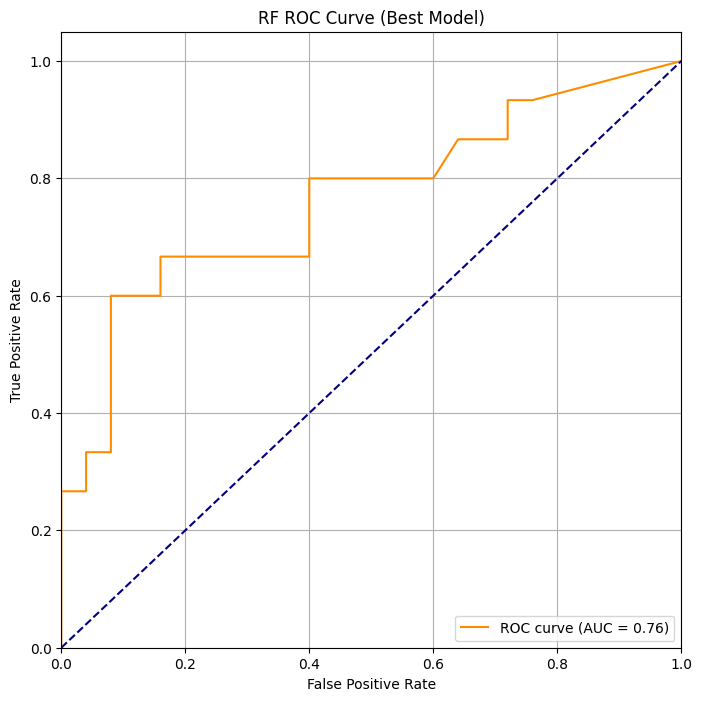

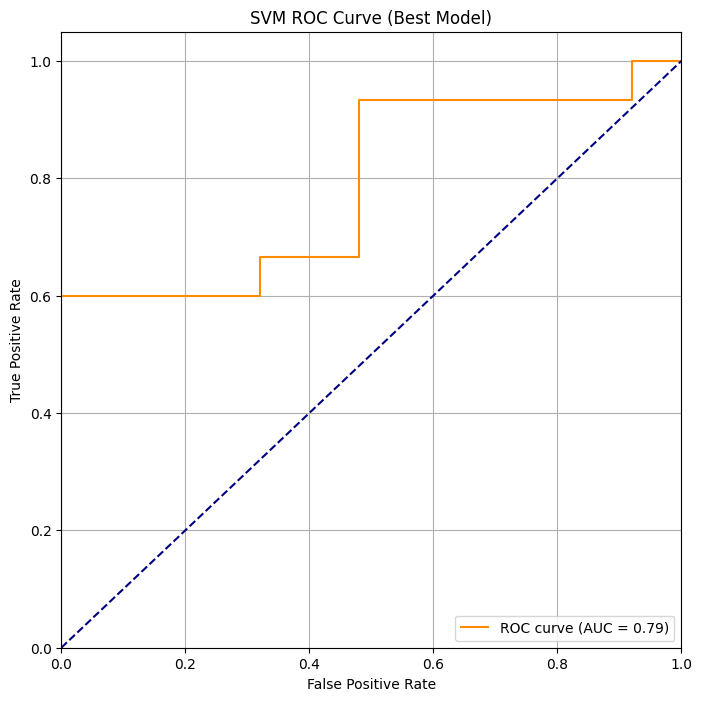

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


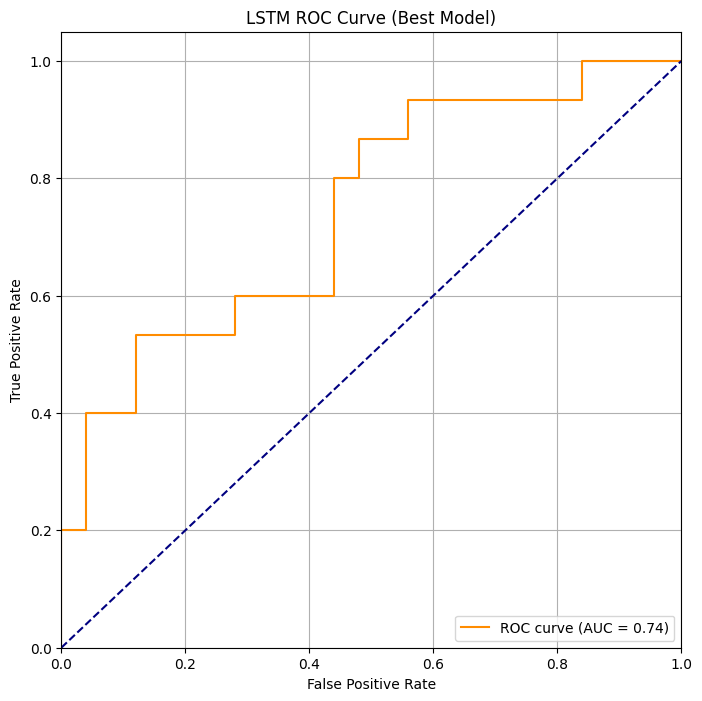

In [17]:
def plot_roc_curves(X_test_std, y_test):
   
    print("\nPlotting ROC curves...")
    colors = {'RF': 'darkorange', 'SVM': 'darkorange', 'LSTM': 'darkorange'}
    
    for name, model_dict in best_models.items():
        plt.figure(figsize=(8, 8))
        model = model_dict['model']
        
        # Handle different prediction methods for LSTM vs RF/SVM
        if name == 'LSTM':
            X_test_reshaped = X_test_std.to_numpy().reshape(-1, 8, 1)
            y_score = model.predict(X_test_reshaped)
        else:
            y_score = model.predict_proba(X_test_std)[:, 1]
        
        # Calculate and plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc_value = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color=colors[name], 
                label=f'ROC curve (AUC = {roc_auc_value:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC Curve (Best Model)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

plot_roc_curves(features_test_all_std,labels_test_all)

In [18]:
def display_mean_metrics(metrics_lists):
    
    metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR',
                     'Precision', 'F1_measure', 'Accuracy', 'Error_rate', 'BACC',
                     'TSS', 'HSS', 'Brier_score', 'AUC', 'Acc_by_package_fn']
    
    # Calculate mean metrics
    avg_metrics = {name: np.mean(metrics, axis=0) 
                  for name, metrics in metrics_lists.items()}
    df = pd.DataFrame(avg_metrics, index=metric_columns)

    # Display summary of key metrics
    key_metrics = ['Accuracy', 'Precision', 'F1_measure', 'AUC', 'BACC']
    summary_df = df.loc[key_metrics]
    
    print("\nSummary of Key Metrics:")
    print("-" * 100)
    print(summary_df.round(3).to_string())
    print("-" * 100)

display_mean_metrics(metrics_lists)


Summary of Key Metrics:
----------------------------------------------------------------------------------------------------
               RF    SVM   LSTM
Accuracy    0.728  0.731  0.733
Precision   0.667  0.692  0.644
F1_measure  0.618  0.604  0.655
AUC         0.812  0.812  0.800
BACC        0.700  0.695  0.723
----------------------------------------------------------------------------------------------------


<b>Performance Analysis and Comparison</b><br>
The models were evaluated using various metrics across 10-fold cross-validation. Key performance indicators:


1.	Random Forest:<br>
•	High accuracy and balanced performance.<br>
•	Strong ROC-AUC scores.<br>
•	Efficient computation time.<br>

2.	SVM:<br>
•	Competitive accuracy.<br>
•	Good generalization on test data.<br>
•	Moderate computation overhead.<br>

3.	LSTM:<br>
•	Comparable accuracy to traditional methods.<br>
•	Higher computational requirements.<br>
•	Potential for improved performance with larger datasets.<br>

4.	ROC Curve Analysis:<br>
•	All models demonstrated strong discriminative ability.<br>
•	ROC curves showed clear separation from the random classifier line.

<b>Conclusion</b><br>
The comparative analysis reveals that while all three models achieve satisfactory performance in diabetes prediction, the Random Forest classifier offers the best balance of accuracy and computational efficiency. The LSTM model, while competitive, requires more computational resources without providing significant performance improvements for this particular dataset 